In [2]:
import clip
import torch
import cv2
import numpy as np
from PIL import Image
from  matplotlib import pyplot as plt
from torch.utils.data import Dataset
from clip.clip_surgery_model import CLIPSurgery
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Initiate CLIP model

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/16", device=device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

## Initiate CLIP_Surgery model


In [5]:
model_surgery, preprocess = clip.load("CS-ViT-B/16", device=device)
model_surgery.eval()

CLIPSurgery(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
   

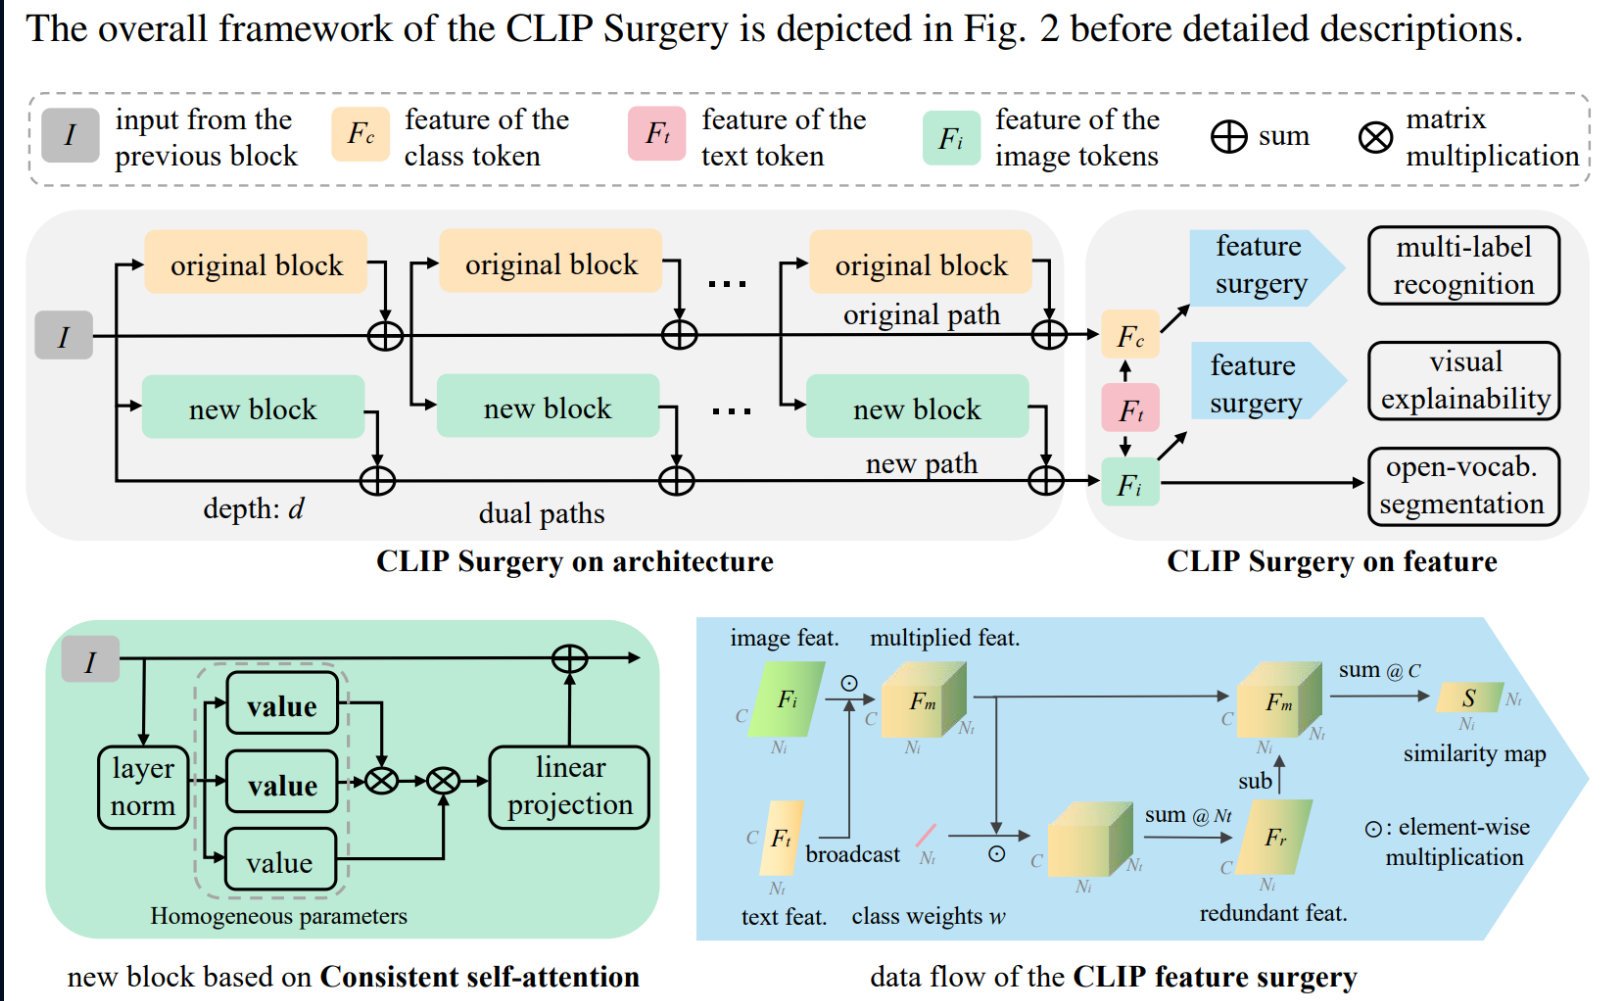

In [23]:
def extract_CLIP_similaritymap(image: torch.Tensor, model, image_size, target_texts, threshold: float = 0.1) -> torch.Tensor:
    with torch.no_grad():
        # image = image.unsqueeze(0).to(device)
        
        # Extract image features
        image_features = model.encode_image(image)
        image_features = image_features / image_features.norm(dim=1, keepdim=True)

        # Prompt ensemble for text features with normalization
        text_features = clip.encode_text_with_prompt_ensemble(model, target_texts, device)

        if type(model) == CLIPSurgery:
            # Apply feature surgery
            similarity = clip.clip_feature_surgery(image_features, text_features)
            
        else:
            # Similarity map from image tokens with min-max norm and resize, B,H,W,N
            similarity = image_features @ text_features.t()

        similarity = torch.where(similarity >= threshold, similarity, 0.0)
        similarity_map = clip.get_similarity_map(similarity[:, 1:, :], image_size)

        return similarity_map

In [8]:
def apply_heatmap(b, n, similarity_map: torch.Tensor, cv2_img: np.array) -> np.array:
    """
    Apply heatmap using similarity map to the original image 
    """
    
    vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
    vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
    vis = cv2_img * 0.4 + vis * 0.6
    vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
    
    return vis

In [9]:
preprocess =  Compose([Resize((224, 224), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])


In [10]:
# '# Define CIFAR-10 dataset transformation (to keep images in PIL format initially)
# cifar_transform = transforms.ToTensor()  # Convert images to tensors (required for dataset loading)

# # Load the CIFAR-10 dataset
# cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)

# # Select one image from the CIFAR-10 dataset
# pil_img, label = cifar10_dataset[0]  # Get the first image and its label (as PIL Image)
# # pil_img = pil_img.permute(1, 2, 0)
# from torchvision.transforms import ToPILImage

# to_pil = ToPILImage()  # Create the transformation
# pil_img = to_pil(pil_img)


In [24]:
target_texts = ['sky', 'person', 'lake', 'mountain', "hair", "house"]

In [14]:
pil_img = Image.open("demo.jpg")

In [15]:

cv2_image = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
image = preprocess(pil_img).unsqueeze(0).to(device)
image_size = cv2_image.shape[:2]


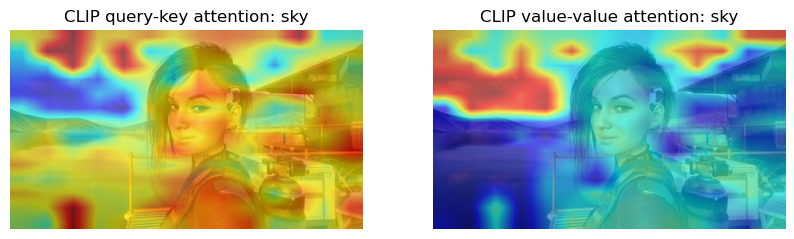

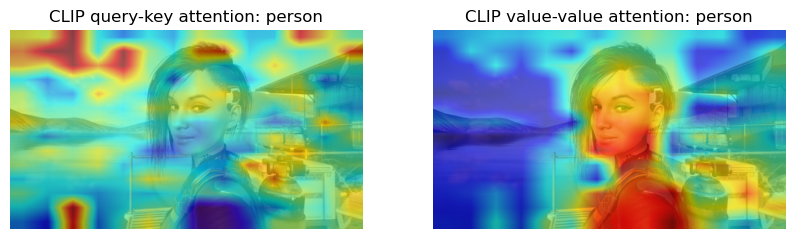

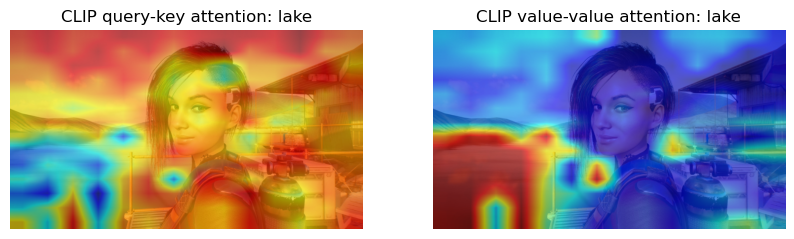

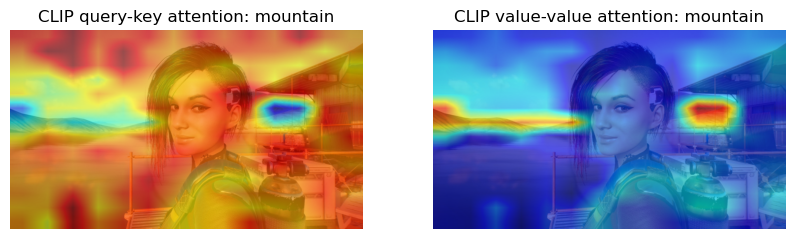

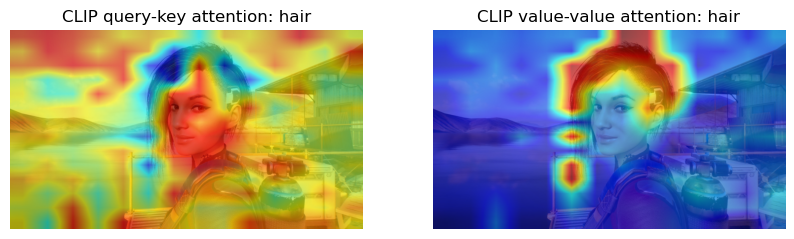

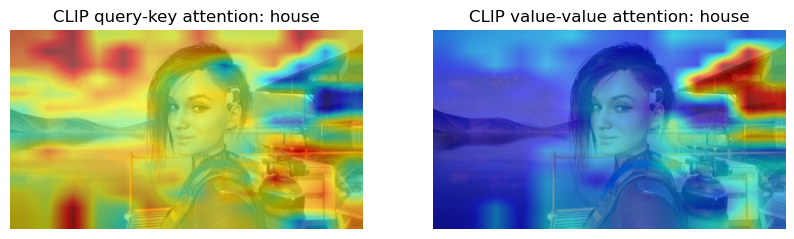

In [ ]:


similarity_map_raw = extract_CLIP_similaritymap(image=image, model=model, image_size=image_size, target_texts=target_texts, threshold=-10.0)
similarity_map = extract_CLIP_similaritymap(image=image, model=model_surgery, image_size=image_size, target_texts=target_texts, threshold=-10.0)

# Draw similarity map
for b in range(similarity_map.shape[0]):
    for n in range(similarity_map.shape[-1]):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        
        label = target_texts[n]
        
        vis_raw = apply_heatmap(b, n, similarity_map=similarity_map_raw, cv2_img=cv2_image)
        vis_surgery = apply_heatmap(b, n, similarity_map=similarity_map, cv2_img=cv2_image)

        ax[0].imshow(vis_raw)
        ax[0].set_title(f'CLIP query-key attention: {label}')
        ax[0].set_axis_off()
        
        ax[1].imshow(vis_surgery)
        ax[1].set_title(f'CLIP value-value attention: {label}')
        ax[1].set_axis_off()
        
        plt.show()

In [27]:
target_texts = ['sword', 'car']

+ The vanilla CLIP cannot detect objects precisely, but CLIP Surgery can detect objects corresponding to the label when objects exist. CLIP Surgery still has a problem when objects don’t exist
+ One of the reasons for this problem is min-max normalization in the postprocessing. When only irrelevant regions are in the activation map, min-max normalization may enhance the difference in their values. To fix this problem, we can simply add a threshold before min-max normalization. In the Flickr dataset case, the relevant region value threshold is more than 0.1, as checked by the histogram of the similarity maps. The results are shown below.

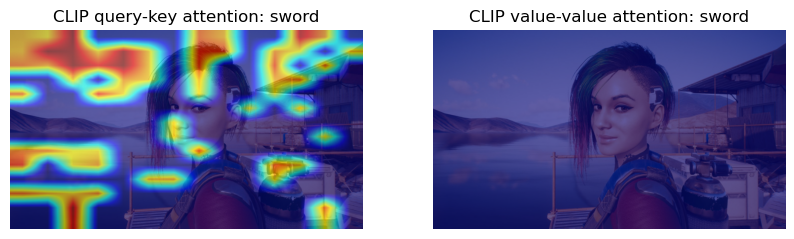

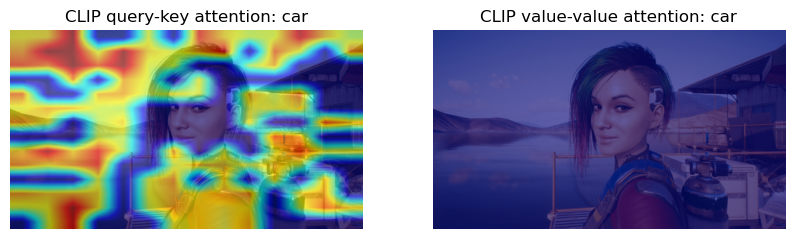

In [28]:

similarity_map_raw = extract_CLIP_similaritymap(image=image, model=model, image_size=image_size, target_texts=target_texts)
similarity_map = extract_CLIP_similaritymap(image=image, model=model_surgery, image_size=image_size, target_texts=target_texts)

# Draw similarity map
for b in range(similarity_map.shape[0]):
    for n in range(similarity_map.shape[-1]):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        
        label = target_texts[n]
        
        vis_raw = apply_heatmap(b, n, similarity_map=similarity_map_raw, cv2_img=cv2_image)
        vis_surgery = apply_heatmap(b, n, similarity_map=similarity_map, cv2_img=cv2_image)

        ax[0].imshow(vis_raw)
        ax[0].set_title(f'CLIP query-key attention: {label}')
        ax[0].set_axis_off()
        
        ax[1].imshow(vis_surgery)
        ax[1].set_title(f'CLIP value-value attention: {label}')
        ax[1].set_axis_off()
        
        plt.show()